# Physics Video Prediction - Training

Train a transformer-based model to predict physics simulation frames.

**Architecture**: CNN Encoder → Transformer → CNN Decoder

**Goal**: Model learns to compress video to latent state that captures physics (position, velocity, etc.)

In [12]:
# Clone repo (for Colab)
!git clone https://github.com/Caleb-Briggs/MNIST_AI.git
%cd MNIST_AI/experiments/physics_prediction

Cloning into 'MNIST_AI'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 130 (delta 29), reused 45 (delta 16), pack-reused 72 (from 1)
Receiving objects: 100% (130/130), 22.90 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/MNIST_AI/experiments/physics_prediction/MNIST_AI/experiments/physics_prediction/MNIST_AI/experiments/physics_prediction


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import HTML
import matplotlib.animation as animation

from physics_sim import (
    Ball, Barrier, PhysicsSimulation,
    generate_trajectory, create_random_simulation, generate_dataset
)
from model import VideoPredictor, count_parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB


## 1. Configuration

In [ ]:
# Data config
NUM_TRAJECTORIES = 2000  # Many trajectories for diverse terrains
FRAMES_PER_TRAJECTORY = 50  # Enough frames for context + rollout
NUM_BARRIERS = 3
WITH_GRAVITY = False  # Start simple

# Model config
LATENT_DIM = 256
N_HEADS = 4
N_LAYERS = 4
MIN_CONTEXT = 4   # Minimum context frames
MAX_CONTEXT = 16  # Maximum context frames  
PREDICT_STEPS = 3  # Always predict this many steps ahead

# Training config
BATCH_SIZE = 64  # Smaller batch since samples have variable sizes
LEARNING_RATE = 3e-4
NUM_EPOCHS = 50
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Context length: {MIN_CONTEXT} to {MAX_CONTEXT} frames")
print(f"Predict {PREDICT_STEPS} steps from each context")

## 2. Generate Training Data

In [15]:
print("Generating training data...")
data = generate_dataset(
    num_trajectories=NUM_TRAJECTORIES,
    num_frames=FRAMES_PER_TRAJECTORY,
    num_barriers=NUM_BARRIERS,
    with_gravity=WITH_GRAVITY,
    base_seed=SEED
)

print(f"Dataset shape: {data.shape}")
print(f"Memory: {data.nbytes / 1024 / 1024:.1f} MB")

# Convert to torch tensor
data_tensor = torch.from_numpy(data).float().unsqueeze(2)  # Add channel dim: (N, T, 1, H, W)
print(f"Tensor shape: {data_tensor.shape}")

Generating training data...
Dataset shape: (2000, 50, 64, 64)
Memory: 1562.5 MB
Tensor shape: torch.Size([2000, 50, 1, 64, 64])


IndexError: index 50 is out of bounds for axis 1 with size 50

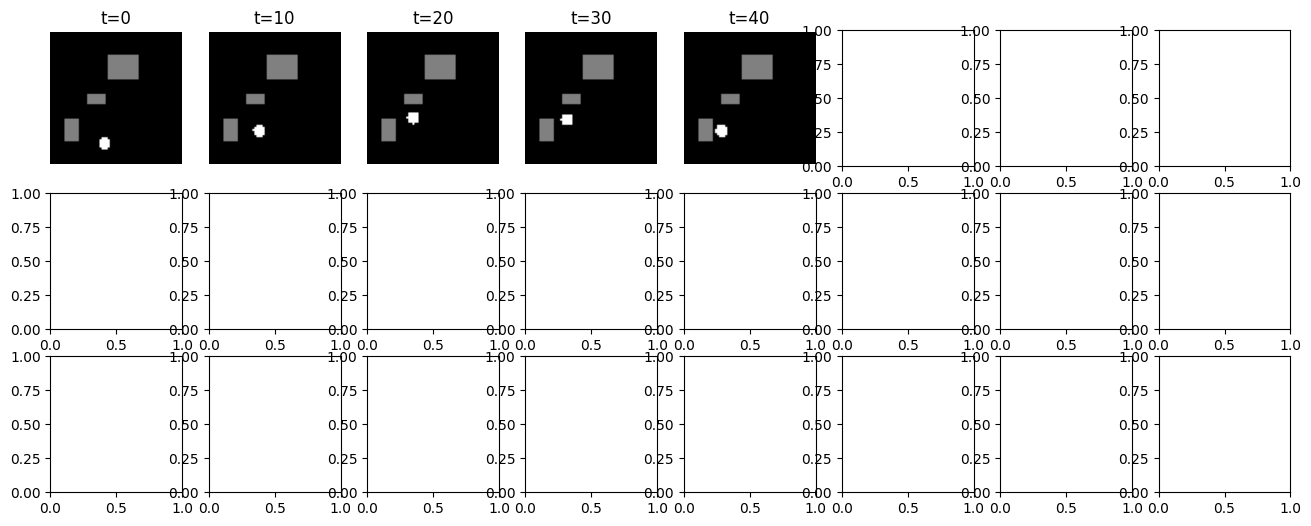

In [16]:
# Visualize a few trajectories
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for row in range(3):
    for col in range(8):
        t = col * 10
        axes[row, col].imshow(data[row, t], cmap='gray', vmin=0, vmax=1)
        if row == 0:
            axes[row, col].set_title(f't={t}')
        axes[row, col].axis('off')
plt.suptitle('Sample Trajectories')
plt.tight_layout()
plt.show()

## 3. Create Dataset and DataLoader

In [ ]:
class PhysicsDataset(torch.utils.data.Dataset):
    """Dataset with variable-length context windows.
    
    For each trajectory, we create multiple samples:
    - Context frames 0:4, predict 4:7
    - Context frames 0:5, predict 5:8
    - Context frames 0:6, predict 6:9
    - ... up to max_context
    
    This trains the model to handle varying context lengths.
    """
    
    def __init__(self, trajectories: torch.Tensor, min_context: int, max_context: int, predict_steps: int):
        """
        Args:
            trajectories: (num_traj, num_frames, 1, H, W)
            min_context: minimum number of context frames
            max_context: maximum number of context frames
            predict_steps: number of future frames to predict
        """
        self.trajectories = trajectories
        self.min_context = min_context
        self.max_context = max_context
        self.predict_steps = predict_steps
        self.num_traj = trajectories.size(0)
        self.num_frames = trajectories.size(1)
        
        # Build index of all valid (trajectory, context_len) pairs
        self.samples = []
        for traj_idx in range(self.num_traj):
            for ctx_len in range(min_context, max_context + 1):
                # Need ctx_len context frames + predict_steps target frames
                if ctx_len + predict_steps <= self.num_frames:
                    self.samples.append((traj_idx, ctx_len))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        traj_idx, ctx_len = self.samples[idx]
        
        # Context: frames 0 to ctx_len (variable length)
        # Targets: frames ctx_len to ctx_len + predict_steps
        context = self.trajectories[traj_idx, :ctx_len]  # (ctx_len, 1, 64, 64)
        targets = self.trajectories[traj_idx, ctx_len:ctx_len + self.predict_steps]  # (predict_steps, 1, 64, 64)
        
        return context, targets


def collate_variable_context(batch):
    """Custom collate function to pad variable-length contexts."""
    contexts, targets = zip(*batch)
    
    # Find max context length in this batch
    max_ctx = max(c.size(0) for c in contexts)
    
    # Pad contexts to max length (pad at the beginning with zeros)
    padded_contexts = []
    context_lengths = []
    for ctx in contexts:
        ctx_len = ctx.size(0)
        context_lengths.append(ctx_len)
        if ctx_len < max_ctx:
            # Pad at beginning: [0, 0, ..., actual_frames]
            padding = torch.zeros(max_ctx - ctx_len, *ctx.shape[1:])
            padded = torch.cat([padding, ctx], dim=0)
        else:
            padded = ctx
        padded_contexts.append(padded)
    
    # Stack into batches
    contexts_batch = torch.stack(padded_contexts)  # (batch, max_ctx, 1, 64, 64)
    targets_batch = torch.stack(targets)  # (batch, predict_steps, 1, 64, 64)
    lengths_batch = torch.tensor(context_lengths)  # (batch,)
    
    return contexts_batch, targets_batch, lengths_batch


# Split into train/val
train_size = int(0.9 * NUM_TRAJECTORIES)
train_data = data_tensor[:train_size]
val_data = data_tensor[train_size:]

train_dataset = PhysicsDataset(train_data, MIN_CONTEXT, MAX_CONTEXT, PREDICT_STEPS)
val_dataset = PhysicsDataset(val_data, MIN_CONTEXT, MAX_CONTEXT, PREDICT_STEPS)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=4, pin_memory=True, collate_fn=collate_variable_context
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True, collate_fn=collate_variable_context
)

print(f"Train samples: {len(train_dataset)} ({train_size} trajectories × {MAX_CONTEXT - MIN_CONTEXT + 1} context lengths)")
print(f"Val samples: {len(val_dataset)}")
print(f"Each sample: variable context ({MIN_CONTEXT}-{MAX_CONTEXT} frames) -> {PREDICT_STEPS} target frames")

## 4. Create Model

In [ ]:
def create_padding_mask(batch_size, max_len, actual_lengths, device):
    """Create padding mask: True for padded positions (at the beginning)."""
    mask = torch.zeros(batch_size, max_len, dtype=torch.bool, device=device)
    for i, length in enumerate(actual_lengths):
        pad_len = max_len - length
        if pad_len > 0:
            mask[i, :pad_len] = True
    return mask


model = VideoPredictor(
    latent_dim=LATENT_DIM,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dim_feedforward=LATENT_DIM * 2,
    dropout=0.1
).to(device)

print(f"Model parameters: {count_parameters(model):,}")

# Test forward pass with variable context
sample_context, sample_target, sample_lengths = next(iter(train_loader))
sample_context = sample_context.to(device)
sample_lengths = sample_lengths.to(device)

# Create padding mask for test
batch_size = sample_context.size(0)
max_ctx = sample_context.size(1)
padding_mask = create_padding_mask(batch_size, max_ctx, sample_lengths, device)

with torch.no_grad():
    sample_pred = model(sample_context, n_future=PREDICT_STEPS, padding_mask=padding_mask)

print(f"Context shape: {sample_context.shape}")
print(f"Context lengths: min={sample_lengths.min().item()}, max={sample_lengths.max().item()}")
print(f"Output shape: {sample_pred.shape}")

## 5. Training Loop

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Loss function: MSE on pixels
criterion = nn.MSELoss()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device, predict_steps):
    """Train with variable-length context and parallel multi-step prediction."""
    model.train()
    total_loss = 0
    total_samples = 0
    
    for context, targets, lengths in loader:
        context = context.to(device)  # (batch, max_ctx, 1, 64, 64)
        targets = targets.to(device)  # (batch, predict_steps, 1, 64, 64)
        lengths = lengths.to(device)  # (batch,)
        
        batch_size = context.size(0)
        max_ctx = context.size(1)
        
        # Create padding mask
        padding_mask = create_padding_mask(batch_size, max_ctx, lengths, device)
        
        optimizer.zero_grad()
        
        # Predict future frames with padding mask
        preds = model(context, n_future=predict_steps, padding_mask=padding_mask)
        
        # MSE loss over all predicted frames
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    return total_loss / total_samples


@torch.no_grad()
def eval_epoch(model, loader, criterion, device, predict_steps):
    """Evaluate with variable-length context."""
    model.eval()
    total_loss = 0
    total_samples = 0
    
    for context, targets, lengths in loader:
        context = context.to(device)
        targets = targets.to(device)
        lengths = lengths.to(device)
        
        batch_size = context.size(0)
        max_ctx = context.size(1)
        
        padding_mask = create_padding_mask(batch_size, max_ctx, lengths, device)
        preds = model(context, n_future=predict_steps, padding_mask=padding_mask)
        
        loss = criterion(preds, targets)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    return total_loss / total_samples


@torch.no_grad()
def quick_visualize(model, val_data, device, epoch, min_ctx=4, max_ctx=16):
    """Quick visualization during training - shows predictions at different context lengths."""
    model.eval()
    
    fig, axes = plt.subplots(3, 6, figsize=(15, 7.5))
    
    # Row 0: Short context (min_ctx frames)
    # Row 1: Medium context (mid frames)  
    # Row 2: Long context (max_ctx frames)
    context_lengths = [min_ctx, (min_ctx + max_ctx) // 2, max_ctx]
    
    for row, ctx_len in enumerate(context_lengths):
        # Get context from first trajectory
        context = val_data[0, :ctx_len].unsqueeze(0).to(device)
        target = val_data[0, ctx_len:ctx_len+3]  # 3 target frames
        
        # Predict
        pred = model(context, n_future=3).cpu().squeeze(0)  # (3, 1, 64, 64)
        
        # Show last 2 context frames
        for i in range(2):
            frame_idx = ctx_len - 2 + i
            axes[row, i].imshow(context[0, -2+i, 0].cpu(), cmap='gray', vmin=0, vmax=1)
            axes[row, i].set_title(f'Ctx t={frame_idx}' if row == 0 else '')
            axes[row, i].axis('off')
        
        # Show 2 predictions vs ground truth (interleaved)
        for t in range(2):
            # Predicted
            axes[row, 2 + t*2].imshow(pred[t, 0].clamp(0, 1), cmap='gray', vmin=0, vmax=1)
            axes[row, 2 + t*2].set_title(f'Pred t+{t+1}' if row == 0 else '')
            axes[row, 2 + t*2].axis('off')
            
            # Ground truth
            axes[row, 3 + t*2].imshow(target[t, 0], cmap='gray', vmin=0, vmax=1)
            axes[row, 3 + t*2].set_title(f'GT t+{t+1}' if row == 0 else '')
            axes[row, 3 + t*2].axis('off')
        
        # Label rows
        axes[row, 0].set_ylabel(f'ctx={ctx_len}', fontsize=12)
    
    plt.suptitle(f'Epoch {epoch} - Predictions at Different Context Lengths')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualization frequency
VIS_EVERY = 10  # Show visualizations every N epochs

print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Variable context: {MIN_CONTEXT}-{MAX_CONTEXT} frames")
print(f"Predict {PREDICT_STEPS} steps ahead")
print("="*60)

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, PREDICT_STEPS)
    val_loss = eval_epoch(model, val_loader, criterion, device, PREDICT_STEPS)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    scheduler.step()
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")
    
    # Periodic visualization
    if (epoch + 1) % VIS_EVERY == 0 or epoch == 0:
        quick_visualize(model, val_data, device, epoch + 1, MIN_CONTEXT, MAX_CONTEXT)

print("="*60)
print("Training complete!")

## 6. Visualizations

### Training Curves

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Learning rate
axes[1].plot(history['lr'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Single-Step Predictions vs Ground Truth

In [ ]:
@torch.no_grad()
def visualize_predictions(model, val_data, device, num_samples=5, context_len=8, num_future=5):
    """Show context, predictions at different horizons, and ground truth."""
    model.eval()
    
    # Columns: last 3 context frames + predicted/GT pairs
    num_cols = 3 + num_future * 2
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(2*num_cols, 2.5*num_samples))
    
    indices = np.random.choice(len(val_data), num_samples, replace=False)
    
    for row, traj_idx in enumerate(indices):
        context = val_data[traj_idx, :context_len].unsqueeze(0).to(device)
        targets = val_data[traj_idx, context_len:context_len + num_future]
        preds = model(context, n_future=num_future).cpu().squeeze(0)
        
        col = 0
        # Show last 3 context frames
        for i in range(3):
            axes[row, col].imshow(context[0, -(3-i), 0].cpu(), cmap='gray', vmin=0, vmax=1)
            if row == 0:
                axes[row, col].set_title(f'Ctx t-{2-i}')
            axes[row, col].axis('off')
            col += 1
        
        # Show predicted and ground truth frames side by side
        for t in range(num_future):
            # Predicted
            axes[row, col].imshow(preds[t, 0].clamp(0, 1), cmap='gray', vmin=0, vmax=1)
            if row == 0:
                axes[row, col].set_title(f'Pred t+{t+1}')
            axes[row, col].axis('off')
            col += 1
            
            # Ground truth
            axes[row, col].imshow(targets[t, 0], cmap='gray', vmin=0, vmax=1)
            if row == 0:
                axes[row, col].set_title(f'GT t+{t+1}')
            axes[row, col].axis('off')
            col += 1
    
    plt.suptitle(f'Context ({context_len} frames) → Predictions vs Ground Truth')
    plt.tight_layout()
    plt.show()

# Test at different context lengths
for ctx_len in [MIN_CONTEXT, (MIN_CONTEXT + MAX_CONTEXT) // 2, MAX_CONTEXT]:
    print(f"\nContext length: {ctx_len}")
    visualize_predictions(model, val_data, device, num_samples=3, context_len=ctx_len, num_future=5)

### Autoregressive Rollouts

In [ ]:
@torch.no_grad()
def visualize_rollout(model, trajectories, device, traj_idx=0, context_len=8, rollout_steps=30):
    """Compare rollout with ground truth at a specific context length."""
    model.eval()
    
    # Get initial context
    context = trajectories[traj_idx, :context_len].unsqueeze(0).to(device)
    
    # Ground truth future
    gt_future = trajectories[traj_idx, context_len:context_len+rollout_steps].cpu().numpy()
    
    # Predict all future frames at once
    predicted = model.rollout(context, rollout_steps).cpu().squeeze().numpy()
    
    # Visualize
    num_show = min(10, rollout_steps)
    step_indices = np.linspace(0, rollout_steps-1, num_show, dtype=int)
    
    fig, axes = plt.subplots(3, num_show, figsize=(2*num_show, 6))
    
    for col, t in enumerate(step_indices):
        # Predicted
        axes[0, col].imshow(predicted[t, 0], cmap='gray', vmin=0, vmax=1)
        if col == 0:
            axes[0, col].set_ylabel('Predicted')
        axes[0, col].set_title(f't+{t+1}')
        axes[0, col].axis('off')
        
        # Ground truth
        axes[1, col].imshow(gt_future[t, 0], cmap='gray', vmin=0, vmax=1)
        if col == 0:
            axes[1, col].set_ylabel('Ground Truth')
        axes[1, col].axis('off')
        
        # Error
        error = np.abs(predicted[t, 0] - gt_future[t, 0])
        axes[2, col].imshow(error, cmap='hot', vmin=0, vmax=0.5)
        if col == 0:
            axes[2, col].set_ylabel('Error')
        axes[2, col].axis('off')
    
    plt.suptitle(f'Rollout ({rollout_steps} steps from {context_len} context frames)')
    plt.tight_layout()
    plt.show()
    
    # Compute MSE over time
    mse_over_time = np.mean((predicted[:, 0] - gt_future[:, 0])**2, axis=(1, 2))
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, rollout_steps+1), mse_over_time)
    plt.xlabel('Rollout Step')
    plt.ylabel('MSE')
    plt.title(f'Prediction Error vs Rollout Length (context={context_len})')
    plt.grid(alpha=0.3)
    plt.show()

# Test at different context lengths
for ctx_len in [MIN_CONTEXT, MAX_CONTEXT]:
    print(f"\n{'='*60}")
    print(f"Context length: {ctx_len}")
    visualize_rollout(model, val_data, device, traj_idx=0, context_len=ctx_len, rollout_steps=30)

### Animated Comparison

In [ ]:
@torch.no_grad()
def animate_rollout_comparison(model, trajectories, device, traj_idx=0, context_len=8, rollout_steps=40):
    """Create side-by-side animation of prediction vs ground truth."""
    model.eval()
    
    # Get data
    context = trajectories[traj_idx, :context_len].unsqueeze(0).to(device)
    gt_future = trajectories[traj_idx, context_len:context_len+rollout_steps].cpu().numpy()
    predicted = model.rollout(context, rollout_steps).cpu().squeeze().numpy()
    
    # Create animation
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    im_pred = axes[0].imshow(predicted[0, 0], cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Predicted')
    axes[0].axis('off')
    
    im_gt = axes[1].imshow(gt_future[0, 0], cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    error = np.abs(predicted[0, 0] - gt_future[0, 0])
    im_err = axes[2].imshow(error, cmap='hot', vmin=0, vmax=0.5)
    axes[2].set_title('Error')
    axes[2].axis('off')
    
    title = fig.suptitle(f'Context={context_len}, t+1')
    
    def update(frame):
        im_pred.set_array(predicted[frame, 0])
        im_gt.set_array(gt_future[frame, 0])
        error = np.abs(predicted[frame, 0] - gt_future[frame, 0])
        im_err.set_array(error)
        title.set_text(f'Context={context_len}, t+{frame+1}')
        return [im_pred, im_gt, im_err, title]
    
    anim = animation.FuncAnimation(fig, update, frames=rollout_steps, interval=100, blit=False)
    plt.close()
    return HTML(anim.to_jshtml())

animate_rollout_comparison(model, val_data, device, traj_idx=0, context_len=MAX_CONTEXT, rollout_steps=40)

## 7. Analysis: Does the Model Learn Physics?

### Latent Space Visualization

In [ ]:
@torch.no_grad()
def analyze_latent_space(model, trajectories, device, num_traj=5):
    """Analyze what the latent space encodes."""
    model.eval()
    
    # Encode several trajectories
    all_latents = []
    for i in range(num_traj):
        traj = trajectories[i].unsqueeze(0).to(device)  # (1, T, 1, H, W)
        latents = model.encode_frames(traj).cpu().numpy()  # (1, T, latent_dim)
        all_latents.append(latents[0])
    
    # Plot latent trajectories (first 3 dimensions)
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = fig.add_subplot(131)
    for i, latents in enumerate(all_latents):
        ax1.plot(latents[:, 0], label=f'Traj {i}')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Latent dim 0')
    ax1.set_title('Latent Dimension 0 Over Time')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = fig.add_subplot(132)
    for i, latents in enumerate(all_latents):
        ax2.plot(latents[:, 1], label=f'Traj {i}')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Latent dim 1')
    ax2.set_title('Latent Dimension 1 Over Time')
    ax2.grid(alpha=0.3)
    
    # 2D projection of latent trajectory
    ax3 = fig.add_subplot(133)
    for i, latents in enumerate(all_latents):
        ax3.plot(latents[:, 0], latents[:, 1], 'o-', markersize=2, alpha=0.7, label=f'Traj {i}')
        ax3.plot(latents[0, 0], latents[0, 1], 'go', markersize=8)  # Start
        ax3.plot(latents[-1, 0], latents[-1, 1], 'ro', markersize=8)  # End
    ax3.set_xlabel('Latent dim 0')
    ax3.set_ylabel('Latent dim 1')
    ax3.set_title('Latent Space Trajectory')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_latent_space(model, val_data, device)

## 8. Save Model

In [ ]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'config': {
        'latent_dim': LATENT_DIM,
        'n_heads': N_HEADS,
        'n_layers': N_LAYERS,
        'context_len': CONTEXT_LEN,
    }
}
torch.save(checkpoint, 'results/model_checkpoint.pt')
print("Model saved to results/model_checkpoint.pt")

## Summary

Key metrics to track:
- **Single-step MSE**: How well does model predict 1 frame ahead?
- **Rollout degradation**: How fast does error grow with longer rollouts?
- **Visual quality**: Do predictions look like valid physics?
- **Latent structure**: Does latent space encode position/velocity?